In [70]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [71]:
#Import Data
local_path = r'/Users/pablouribepizarro/Desktop/Analisis de Datos/Tarea_1/'
datos = pd.read_csv(local_path + 'data_new_features_clean.csv',index_col =0)


In [72]:
#Transform Data into Numerical:

datos['FechaNac'] = pd.to_datetime(datos['FechaNac'])
datos['FechaReserva'] = pd.to_datetime(datos['FechaReserva'])
datos['FechaCita'] = pd.to_datetime(datos['FechaCita'])
datos = datos.sort_values('FechaCita')

In [73]:
datos.dtypes

PAID                               float64
FechaNac                    datetime64[ns]
Sexo                                object
Comuna                              object
Provincia                           object
Region                              object
Agenda                              object
TipoProfesional                     object
Especialidad                        object
TipoAtencion                        object
CodPrestacion                      float64
Prestacion                          object
FechaReserva                datetime64[ns]
FechaCita                   datetime64[ns]
EstadoCita                          object
Edad                               float64
DiasReservaCita                      int64
Dia Cita                             int64
Distancia                            int64
Reservas Anteriores                  int64
Cancelaciones Anteriores             int64
Atenciones Anteriores                int64
No Atenciones Anteriores             int64
dtype: obje

In [74]:
#Encode Data into Numerical
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


column_list = [] #str columns
for column in datos.columns:
    if datos[column].dtype == 'O':
        column_list.append(column)

datos_num = datos[column_list].astype(str).apply(le.fit_transform)
for column in datos.columns:
    if datos[column].dtype != 'O':
        datos_num[column] = datos[column]

In [75]:
datos_num.dtypes

Sexo                                 int64
Comuna                               int64
Provincia                            int64
Region                               int64
Agenda                               int64
TipoProfesional                      int64
Especialidad                         int64
TipoAtencion                         int64
Prestacion                           int64
EstadoCita                           int64
PAID                               float64
FechaNac                    datetime64[ns]
CodPrestacion                      float64
FechaReserva                datetime64[ns]
FechaCita                   datetime64[ns]
Edad                               float64
DiasReservaCita                      int64
Dia Cita                             int64
Distancia                            int64
Reservas Anteriores                  int64
Cancelaciones Anteriores             int64
Atenciones Anteriores                int64
No Atenciones Anteriores             int64
dtype: obje

In [76]:
#sns.pairplot(datos[['Sexo', 'TipoAtencion', 'Prestacion','Edad',
                     #'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    #'Distancia','Dia Cita','EstadoCita']], hue='EstadoCita')

In [77]:
#Create Balanced Subset:
datos_cancelaciones = datos.loc[datos['EstadoCita'] == 'Cancelado'].copy()
datos_atenciones = datos.loc[datos['EstadoCita'] == 'Atendido'].copy()
datos_noatenciones = datos.loc[datos['EstadoCita'] == 'No Atendido'].copy()

num = min(datos_cancelaciones.shape[0],datos_atenciones.shape[0],datos_noatenciones.shape[0])
cancelaciones_sample = datos_cancelaciones.sample(num)
atenciones_sample = datos_atenciones.sample(num)
noatenciones_sample = datos_noatenciones.sample(num)

balanced_sample = pd.concat([cancelaciones_sample,atenciones_sample,noatenciones_sample]).sample(frac=1)

In [78]:
#Encode Data into Numerical
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


column_list = [] #str columns
for column in datos.columns:
    if balanced_sample[column].dtype == 'O':
        column_list.append(column)

datos_num = balanced_sample[column_list].astype(str).apply(le.fit_transform)
for column in balanced_sample.columns:
    if balanced_sample[column].dtype != 'O':
        datos_num[column] = balanced_sample[column]

In [79]:
balanced_sample.dtypes

PAID                               float64
FechaNac                    datetime64[ns]
Sexo                                object
Comuna                              object
Provincia                           object
Region                              object
Agenda                              object
TipoProfesional                     object
Especialidad                        object
TipoAtencion                        object
CodPrestacion                      float64
Prestacion                          object
FechaReserva                datetime64[ns]
FechaCita                   datetime64[ns]
EstadoCita                          object
Edad                               float64
DiasReservaCita                      int64
Dia Cita                             int64
Distancia                            int64
Reservas Anteriores                  int64
Cancelaciones Anteriores             int64
Atenciones Anteriores                int64
No Atenciones Anteriores             int64
dtype: obje

In [84]:
#Standardize Data
from sklearn import preprocessing
stand_data = preprocessing.StandardScaler().fit_transform(datos_num.drop(
                                                ['FechaNac','FechaCita','FechaReserva','EstadoCita'],axis=1))
stand_data = pd.DataFrame(stand_data)
stand_data.columns = datos_num.drop(
                                        ['FechaNac','FechaCita','FechaReserva','EstadoCita'],axis=1).columns.values
stand_data['EstadoCita'] = datos_num['EstadoCita']

In [85]:
#Create Training set Sample and Validation set
msk = np.random.rand(len(datos_num)) < 0.5
train = datos_num[msk]
test = datos_num[~msk]

In [86]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Score: 0.4196412393549556
Feature Importances: [0.11050506 0.30881569 0.10320359 0.05013392 0.20060973 0.10569301
 0.03392727 0.07244001 0.0146717 ]


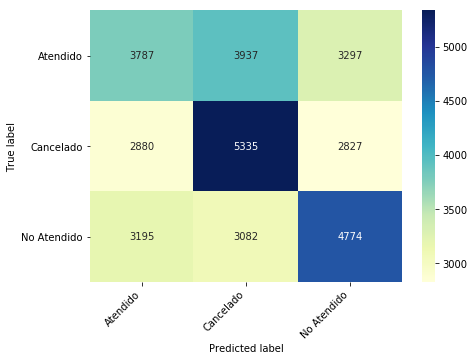

In [87]:
#Decision Tree Classifiers
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

#Orginal Variables

clf1 = DecisionTreeClassifier(random_state=0,criterion='entropy')
clf1.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], train['EstadoCita'])
score = clf1.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], test['EstadoCita'])
print('Score: '+str(score))
print('Feature Importances: '+str(clf1.feature_importances_))

#Confussion Matrix

y_pred = clf1.predict(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']])
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'],y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

Score: 0.42033580962734796
Feature Importance: [0.03591307 0.10949906 0.022556   0.01228203 0.03356995 0.01238778
 0.00378918 0.02295383 0.00590818 0.30113519 0.18834277 0.05719892
 0.04179657 0.05036002 0.02874389 0.00948904 0.06407453]


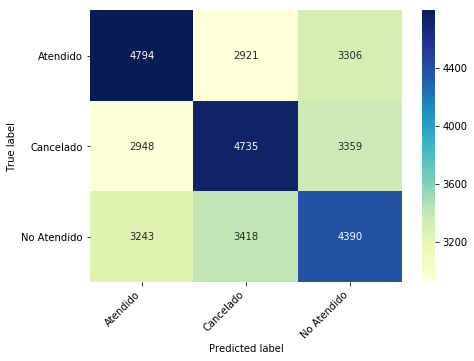

In [88]:
#New Variables

clf2 = DecisionTreeClassifier(random_state=0,criterion='entropy')
clf2.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda',
                   'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']], train['EstadoCita'])

score = clf2.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']], test['EstadoCita'])
print('Score: '+str(score))
print('Feature Importance: '+str(clf2.feature_importances_))

#Confussion Matrix
y_pred=clf2.predict(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']])
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

Score: 0.42302349459443134


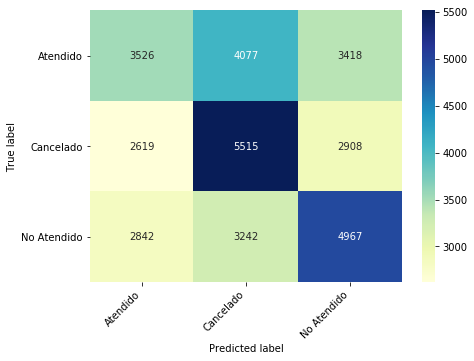

In [89]:
#BaggedTrees: Original Features
from sklearn.ensemble import BaggingClassifier
btc1 = BaggingClassifier(base_estimator= DecisionTreeClassifier(random_state=0,criterion='entropy'),
                         n_estimators=50,max_samples=0.9,max_features=0.8,bootstrap_features=True)
btc1.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], train['EstadoCita'])
score = btc1.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], test['EstadoCita'])
print('Score: '+str(score))


#Confussion Matrix

y_pred = btc1.predict(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']])
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'],y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

Score: 0.47970646856314547


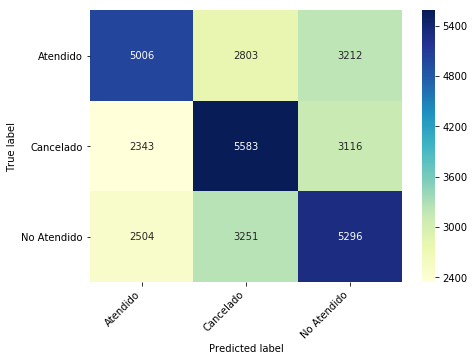

In [90]:
#BaggedTrees: New Features
from sklearn.ensemble import BaggingClassifier
btc2 = BaggingClassifier(base_estimator= DecisionTreeClassifier(random_state=0,criterion='entropy'),
                         n_estimators=50,max_samples=0.5,max_features=0.8,bootstrap_features=True)
btc2.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda',
                   'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']], train['EstadoCita'])
score = btc2.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']], test['EstadoCita'])
print('Score: '+str(score))
#Confussion Matrix
y_pred=btc2.predict(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']])
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

In [ ]:
#Neuronal Network
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,ReLU
from keras.optimizers import SGD

# Generate dummy data
x_train = train[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']]
y_train = keras.utils.to_categorical(train['EstadoCita'])
x_test = test[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']]
y_test = keras.utils.to_categorical(test['EstadoCita'])

model = Sequential()
model.add(Dense(20, activation='relu', input_dim=11))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_hinge',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=10,
          batch_size=128)
score = model.evaluate(x_test, y_test, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
33228/33228 [==============================] - 3s 82us/step - loss: 1.0489 - acc: 0.3308
Epoch 2/10
33228/33228 [==============================] - 1s 45us/step - loss: 0.9939 - acc: 0.3410
Epoch 3/10
33228/33228 [==============================] - 1s 44us/step - loss: 0.9800 - acc: 0.3437
Epoch 4/10
33228/33228 [==============================] - 1s 41us/step - loss: 0.9701 - acc: 0.3438
Epoch 5/10
33228/33228 [==============================] - 1s 41us/step - loss: 0.9675 - acc: 0.3431
Epoch 6/10
33228/33228 [==============================] - 2s 49us/step - loss: 0.9635 - acc: 0.3446
Epoch 7/10
33228/33228 [==============================] - 2s 48us/step - loss: 0.9589 - acc: 0.3460
Epoch 8/10
33228/33228 [==============================] - 1s 44us/step - loss: 0.9576 - acc: 0.3475
Epoch 9/10
33228/33228 [==============================] - 1s 45us/step - l

In [ ]:
y_pred=np.argmax(model.predict(test[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']]),axis=1)

class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

In [ ]:
#Neuronal Network: Logistic Regression Architecture
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,ReLU
from keras.optimizers import SGD

# Generate dummy data
x_train = train[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']]
y_train = keras.utils.to_categorical(train['EstadoCita'])
x_test = test[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']]
y_test = keras.utils.to_categorical(test['EstadoCita'])

model = Sequential()
model.add(Dense(3, activation='sigmoid',input_dim=11))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_hinge',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=10,
          batch_size=128)
score = model.evaluate(x_test, y_test, batch_size=128)

In [ ]:
y_pred=np.argmax(model.predict(test[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']]),axis=1)

class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

In [21]:
#Support Vector Machine: Original Features
from sklearn import svm
clf = svm.LinearSVC(C= 0.1)
clf.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda',
                   'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion']], train['EstadoCita']) 

/Users/pablouribepizarro/anaconda3/envs/keras_ts/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [22]:
score = clf.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion']], test['EstadoCita'])

In [23]:
score

0.3956133470101973

In [27]:
#Support Vector Machine: New features
s
clf = svm.LinearSVC(C=0.5)
clf.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda',
                   'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']], train['EstadoCita']) 

/Users/pablouribepizarro/anaconda3/envs/keras_ts/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [28]:
score = clf.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']], test['EstadoCita'])

In [31]:
#Support Vector Machine: New features
from sklearn import svm
clf = svm.SVC(C=0.5, decision_function_shape='ovo', gamma = 'scale')
clf.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda',
                   'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']], train['EstadoCita']) 

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [33]:
score = clf.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']], test['EstadoCita'])

In [ ]:
#Support Vector Machine: New features
from sklearn import svm
clf = svm.SVC(C=0.5, decision_function_shape='ovo', kernel='poly', degree=3)
clf.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda',
                   'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']], train['EstadoCita']) 

/Users/pablouribepizarro/anaconda3/envs/keras_ts/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
